# Data cleaning and preprocessing

In [1]:
# Import libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE
!pip install xgboost

In [2]:
# Data loading
BookData = pd.read_csv("ForecastDataBookings.csv")

In [4]:
# Split dataset

# Splitting training+Validationset and testset (70/30)
X_train_val, X_test, y_train_val, y_test = train_test_split(BookData.drop(columns=['Status']),  BookData['Status'],  test_size=0.3,  random_state=42)

# Splitting trainingset and validationset (70: 80/20)
X_train, X_val, y_train, y_val = train_test_split(X_train_val,  y_train_val,  test_size=0.2,  random_state=42)

In [5]:
# Missing values

# Impute missing values with mode for the features Children and Country
# Mode of the trainset
ModeChildren = X_train['Children'].mode()[0]
ModeCountry = X_train['Country'].mode()[0]

# Feature: Children
X_train['Children'] = X_train['Children'].fillna(X_train['Children'].mode()[0])
X_val['Children'] = X_val['Children'].fillna(X_train['Children'].mode()[0])
X_test['Children'] = X_test['Children'].fillna(X_train['Children'].mode()[0])

# Feature: Country
X_train['Country'] = X_train['Country'].fillna(X_train['Country'].mode()[0])
X_val['Country'] = X_val['Country'].fillna(X_train['Country'].mode()[0])
X_test['Country'] = X_test['Country'].fillna(X_train['Country'].mode()[0])


# Drop features because many NULL values, and both have over 300 classes. Computational expensive
#Feature: Agent and Company
X_train = X_train.drop(['Agent', 'Company'], axis=1)
X_val = X_val.drop(['Agent', 'Company'], axis=1)
X_test = X_test.drop(['Agent', 'Company'], axis=1)


In [6]:
# One-hot-encoding for categorical features

# Transform feature IsRepeatedGuest to a category
X_train['IsRepeatedGuest'] = X_train['IsRepeatedGuest'].astype('category')
X_val['IsRepeatedGuest'] = X_val['IsRepeatedGuest'].astype('category')
X_test['IsRepeatedGuest'] = X_test['IsRepeatedGuest'].astype('category')

# Top 25 + Other for feature Country (Top 25 from trainset)
TopN = 25
TopCountries = X_train['Country'].value_counts().nlargest(TopN).index
X_train['Country'] = X_train['Country'].apply(lambda x: x if x in TopCountries else 'Other')
X_val['Country'] = X_val['Country'].apply(lambda x: x if x in TopCountries else 'Other')
X_test['Country'] = X_test['Country'].apply(lambda x: x if x in TopCountries else 'Other')

# All categorical features
CategoricalFeatures = ['Country',
                       'Hotel',
                       'Meal',
                       'MarketSegment',
                       'DistributionChannel',
                       'ReservedRoomType',
                       'AssignedRoomType',
                       'DepositType',
                       'CustomerType',
                       'IsRepeatedGuest']

# One-hot-encoding CategoricalFeatures
X_train = pd.get_dummies(X_train, columns=CategoricalFeatures, drop_first=False)
X_val = pd.get_dummies(X_val, columns=CategoricalFeatures, drop_first=False)
X_test = pd.get_dummies(X_test, columns=CategoricalFeatures, drop_first=False)

# Consistency between train, validation and test sets
X_train, X_val = X_train.align(X_val, join='left', axis=1)
X_train, X_test = X_train.align(X_test, join='left', axis=1)



In [7]:
# Processing date features

# ArrivalDateMonth from Object to Integer
MonthChange = {
                'January': 1,
                'February': 2,
                'March': 3,
                'April': 4,
                'May': 5,
                'June': 6,
                'July': 7,
                'August': 8,
                'September': 9,
                'October': 10,
                'November': 11,
                'December': 12
            }

X_train['ArrivalDateMonth'] = X_train['ArrivalDateMonth'].map(MonthChange)
X_val['ArrivalDateMonth'] = X_val['ArrivalDateMonth'].map(MonthChange)
X_test['ArrivalDateMonth'] = X_test['ArrivalDateMonth'].map(MonthChange)

# Sinus- and cosinustransformation (Arrival month)
X_train['ArrivalDateMonth_Sin'] = np.sin(2 * np.pi * X_train['ArrivalDateMonth'] / 12)
X_train['ArrivalDateMonth_Cos'] = np.cos(2 * np.pi * X_train['ArrivalDateMonth'] / 12)

X_val['ArrivalDateMonth_Sin'] = np.sin(2 * np.pi * X_val['ArrivalDateMonth'] / 12)
X_val['ArrivalDateMonth_Cos'] = np.cos(2 * np.pi * X_val['ArrivalDateMonth'] / 12)

X_test['ArrivalDateMonth_Sin'] = np.sin(2 * np.pi * X_test['ArrivalDateMonth'] / 12)
X_test['ArrivalDateMonth_Cos'] = np.cos(2 * np.pi * X_test['ArrivalDateMonth'] / 12)

# Sinus- and cosinustransformation (Arrival week). Dataset has 53 weeks in a year.
X_train['ArrivalDateWeekNumber_Sin'] = np.sin(2 * np.pi * X_train['ArrivalDateWeekNumber'] / 53)
X_train['ArrivalDateWeekNumber_Cos'] = np.cos(2 * np.pi * X_train['ArrivalDateWeekNumber'] / 53)

X_val['ArrivalDateWeekNumber_Sin'] = np.sin(2 * np.pi * X_val['ArrivalDateWeekNumber'] / 53)
X_val['ArrivalDateWeekNumber_Cos'] = np.cos(2 * np.pi * X_val['ArrivalDateWeekNumber'] / 53)

X_test['ArrivalDateWeekNumber_Sin'] = np.sin(2 * np.pi * X_test['ArrivalDateWeekNumber'] / 53)
X_test['ArrivalDateWeekNumber_Cos'] = np.cos(2 * np.pi * X_test['ArrivalDateWeekNumber'] / 53)

# Sinus- and cosinustransformation (Arrival day of month)

# Function: Check if the year is a leap year
def IsLeapYear(year):
    return year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)

# Function: Assign number of days to the months, including the leap year difference for February
def NumberOfDaysInMonth(month, year):
    if month == 2:
        return 29 if IsLeapYear(year) else 28
    return 31 if month in [1, 3, 5, 7, 8, 10, 12] else 30

X_train['ArrivalDateDay_Sin'] = X_train.apply(lambda row: np.sin(2 * np.pi * row['ArrivalDateDayOfMonth'] / NumberOfDaysInMonth(row['ArrivalDateMonth'], row['ArrivalDateYear'])), axis=1)
X_train['ArrivalDateDay_Cos'] = X_train.apply(lambda row: np.cos(2 * np.pi * row['ArrivalDateDayOfMonth'] / NumberOfDaysInMonth(row['ArrivalDateMonth'], row['ArrivalDateYear'])), axis=1)

X_val['ArrivalDateDay_Sin'] = X_val.apply(lambda row: np.sin(2 * np.pi * row['ArrivalDateDayOfMonth'] / NumberOfDaysInMonth(row['ArrivalDateMonth'], row['ArrivalDateYear'])), axis=1)
X_val['ArrivalDateDay_Cos'] = X_val.apply(lambda row: np.cos(2 * np.pi * row['ArrivalDateDayOfMonth'] / NumberOfDaysInMonth(row['ArrivalDateMonth'], row['ArrivalDateYear'])), axis=1)

X_test['ArrivalDateDay_Sin'] = X_test.apply(lambda row: np.sin(2 * np.pi * row['ArrivalDateDayOfMonth'] / NumberOfDaysInMonth(row['ArrivalDateMonth'], row['ArrivalDateYear'])), axis=1)
X_test['ArrivalDateDay_Cos'] = X_test.apply(lambda row: np.cos(2 * np.pi * row['ArrivalDateDayOfMonth'] / NumberOfDaysInMonth(row['ArrivalDateMonth'], row['ArrivalDateYear'])), axis=1)

In [8]:
# Drop features that are correlated to other features in the dataset

features_to_drop = ['ArrivalDateMonth', 'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth', 'StaysInNights', 'ArrivalDate', 'CheckoutDate', 'ReservationStatusDate']

X_train = X_train.drop(features_to_drop, axis=1)
X_val = X_val.drop(features_to_drop, axis=1)
X_test = X_test.drop(features_to_drop, axis=1)

# Model XGBoost

In [9]:
# import libraries

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from imblearn.pipeline import Pipeline

## XGBoost without SMOTE

In [ ]:
# Label encoding for target value

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
# XGBoost on trainings with smote

xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train_encoded)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
param_dist = {
    'n_estimators': [100, 150, 200],
    'max_depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'gamma': [0.1, 0.3, 0.5],
    'min_child_weight': [1, 3, 5],
    'reg_lambda': [0.1, 1.0, 5.0],
    'reg_alpha': [0.1, 0.5, 1.0]
}


In [ ]:
# RandomizedSearch
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='f1_weighted'
)


random_search.fit(X_train, y_train_encoded)

print(f"Best parameters found: {random_search.best_params_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found: {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'n_estimators': 150, 'min_child_weight': 5, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 0.6}


In [ ]:
# Using best model for prediction
best_xgb = random_search.best_estimator_

y_train_pred = random_search.best_estimator_.predict(X_train)
y_val_pred = random_search.best_estimator_.predict(X_val)
y_test_pred = random_search.best_estimator_.predict(X_test)

Train Set Results
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     42189
           1       0.86      0.86      0.86     19191
           2       0.89      0.37      0.52      4786
           3       0.96      0.22      0.36       692

    accuracy                           0.87     66858
   macro avg       0.90      0.60      0.66     66858
weighted avg       0.88      0.87      0.86     66858



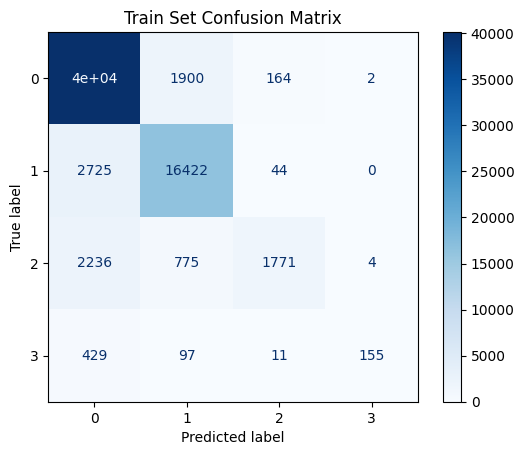

Validation Set Results
              precision    recall  f1-score   support

           0       0.87      0.94      0.90     10499
           1       0.83      0.84      0.84      4817
           2       0.80      0.29      0.43      1233
           3       0.91      0.13      0.22       166

    accuracy                           0.85     16715
   macro avg       0.85      0.55      0.60     16715
weighted avg       0.85      0.85      0.84     16715



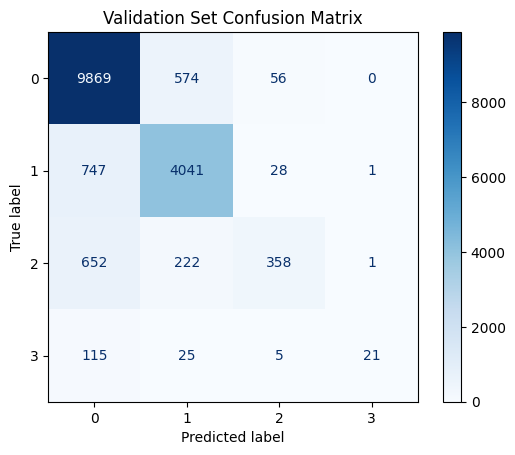

Test Set Results
              precision    recall  f1-score   support

           0       0.87      0.94      0.90     22478
           1       0.83      0.82      0.83     10433
           2       0.80      0.31      0.44      2557
           3       0.85      0.09      0.17       349

    accuracy                           0.85     35817
   macro avg       0.84      0.54      0.59     35817
weighted avg       0.85      0.85      0.84     35817



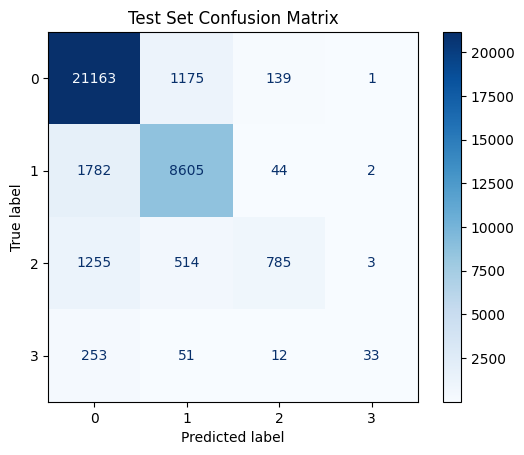

In [ ]:
# Confusion matrix for train, validation and test results
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Train
print("Train Set Results")
print(classification_report(y_train_encoded, y_train_pred))
train_cm = confusion_matrix(y_train_encoded, y_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=train_cm)
disp.plot(cmap=plt.cm.Blues, colorbar=True)
plt.title("Train Set Confusion Matrix")
plt.show()

# Validation
print("Validation Set Results")
print(classification_report(y_val_encoded, y_val_pred))
val_cm = confusion_matrix(y_val_encoded, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=val_cm)
disp.plot(cmap=plt.cm.Blues, colorbar=True)
plt.title("Validation Set Confusion Matrix")
plt.show()

# Test
print("Test Set Results")
print(classification_report(y_test_encoded, y_test_pred))
test_cm = confusion_matrix(y_test_encoded, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm)
disp.plot(cmap=plt.cm.Blues, colorbar=True)
plt.title("Test Set Confusion Matrix")
plt.show()


## XGBoost with SMOTE

In [10]:
# Label encoding for target value

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

In [11]:
# Smote for class imbalances

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train_encoded)

print("Class distribution before SMOTE:", Counter(y_train_encoded))
print("Class distribution after SMOTE:", Counter(y_train_smote))


Class distribution before SMOTE: Counter({0: 42189, 1: 19191, 2: 4786, 3: 692})
Class distribution after SMOTE: Counter({0: 42189, 2: 42189, 1: 42189, 3: 42189})


In [12]:
# XGBoost on trainings with smote

xgb = XGBClassifier(random_state=42)
xgb.fit(X_train_smote, y_train_smote)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [13]:
param_dist = {
    'n_estimators': [100, 150, 200],
    'max_depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'gamma': [0.1, 0.3, 0.5],
    'min_child_weight': [1, 3, 5],
    'reg_lambda': [0.1, 1.0, 5.0],
    'reg_alpha': [0.1, 0.5, 1.0]
}


In [14]:
# RandomizedSearch
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='f1_weighted'
)

# Pas RandomizedSearch aan op originele trainingsdata (zonder SMOTE)
random_search.fit(X_train_smote, y_train_smote)

print(f"Best parameters found: {random_search.best_params_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found: {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'n_estimators': 150, 'min_child_weight': 5, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 0.6}


In [15]:
# Using best model for prediction
best_xgb = random_search.best_estimator_

y_train_pred = random_search.best_estimator_.predict(X_train_smote)
y_val_pred = random_search.best_estimator_.predict(X_val)
y_test_pred = random_search.best_estimator_.predict(X_test)

Train Set Results
              precision    recall  f1-score   support

           0       0.89      0.92      0.90     42189
           1       0.89      0.87      0.88     42189
           2       0.92      0.88      0.90     42189
           3       0.95      0.98      0.96     42189

    accuracy                           0.91    168756
   macro avg       0.91      0.91      0.91    168756
weighted avg       0.91      0.91      0.91    168756



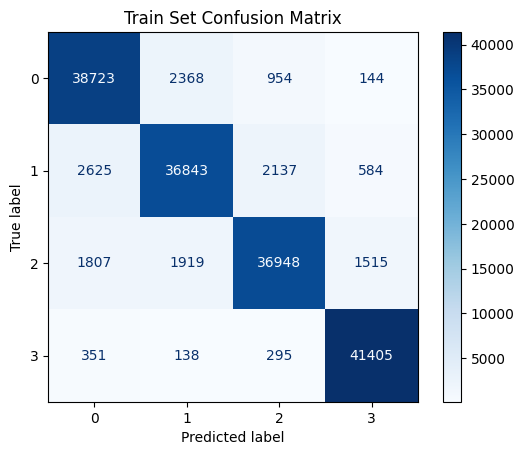

Validation Set Results
              precision    recall  f1-score   support

           0       0.88      0.91      0.89     10499
           1       0.82      0.84      0.83      4817
           2       0.56      0.41      0.47      1233
           3       0.33      0.20      0.25       166

    accuracy                           0.84     16715
   macro avg       0.65      0.59      0.61     16715
weighted avg       0.84      0.84      0.84     16715



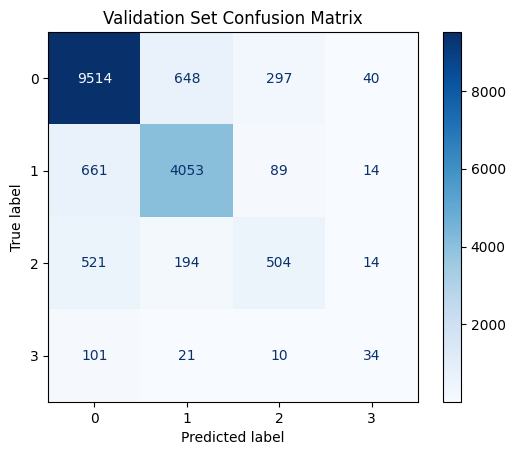

Test Set Results
              precision    recall  f1-score   support

           0       0.88      0.91      0.89     22478
           1       0.82      0.83      0.82     10433
           2       0.56      0.43      0.49      2557
           3       0.34      0.20      0.25       349

    accuracy                           0.84     35817
   macro avg       0.65      0.59      0.61     35817
weighted avg       0.84      0.84      0.84     35817



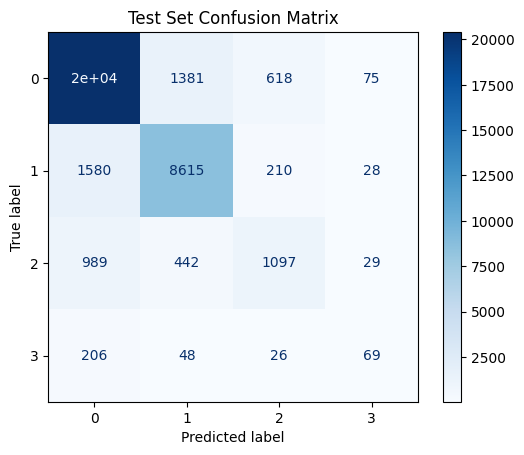

In [16]:
# Confusion matrix for train, validation and test results
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Train
print("Train Set Results")
print(classification_report(y_train_smote, y_train_pred))  # Gebruik originele labels (niet de SMOTE)
train_cm = confusion_matrix(y_train_smote, y_train_pred)  # Gebruik originele labels
disp = ConfusionMatrixDisplay(confusion_matrix=train_cm)
disp.plot(cmap=plt.cm.Blues, colorbar=True)
plt.title("Train Set Confusion Matrix")
plt.show()

# Validation
print("Validation Set Results")
print(classification_report(y_val_encoded, y_val_pred))  # Gebruik originele labels van de validatie set
val_cm = confusion_matrix(y_val_encoded, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=val_cm)
disp.plot(cmap=plt.cm.Blues, colorbar=True)
plt.title("Validation Set Confusion Matrix")
plt.show()

# Test
print("Test Set Results")
print(classification_report(y_test_encoded, y_test_pred))  # Gebruik originele labels van de test set
test_cm = confusion_matrix(y_test_encoded, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm)
disp.plot(cmap=plt.cm.Blues, colorbar=True)
plt.title("Test Set Confusion Matrix")
plt.show()


## Feature importance analysis

In [17]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

# Permutation importance calculation on the validation set
perm_importance = permutation_importance(best_xgb, X_val, y_val_encoded, n_repeats=10, random_state=42, scoring='f1_macro')

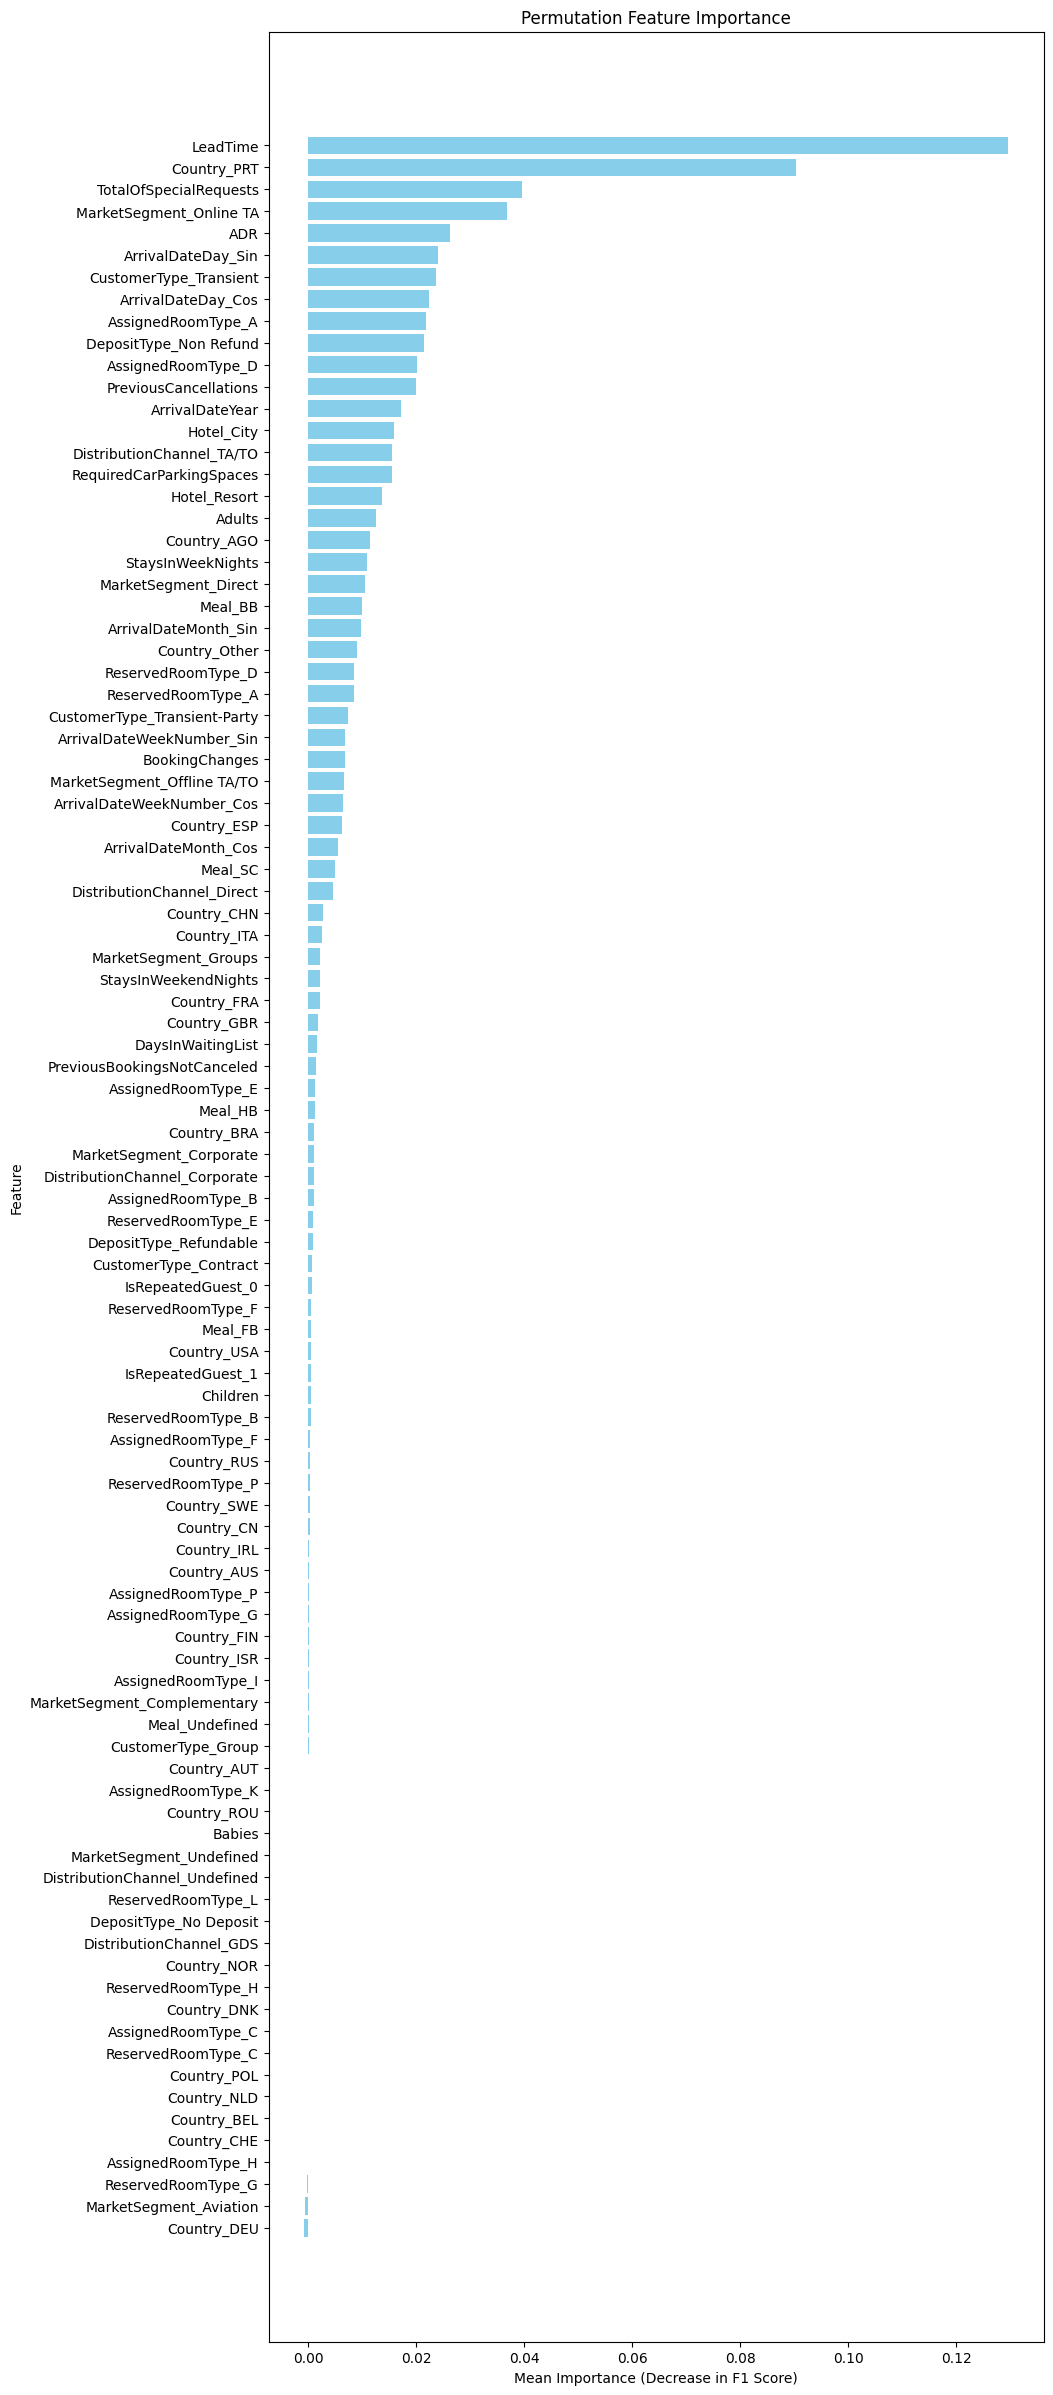

                    Feature  Mean Importance  Importance StdDev
95                 LeadTime         0.129653           0.005417
94              Country_PRT         0.090396           0.003020
93   TotalOfSpecialRequests         0.039543           0.003019
92  MarketSegment_Online TA         0.036786           0.002102
91                      ADR         0.026278           0.003280
..                      ...              ...                ...
4               Country_CHE        -0.000090           0.000116
3        AssignedRoomType_H        -0.000122           0.000433
2        ReservedRoomType_G        -0.000208           0.000350
1    MarketSegment_Aviation        -0.000538           0.000092
0               Country_DEU        -0.000826           0.000694

[96 rows x 3 columns]


In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Sorting the results
sorted_idx = perm_importance.importances_mean.argsort()

# Getting the feature names for plotting
feature_names = X_train.columns

# Visualisation of the permutation importance analysis
plt.figure(figsize=(10, 30))
plt.barh(feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx], color='skyblue')
plt.xlabel("Mean Importance (Decrease in F1 Score)")
plt.ylabel("Feature")
plt.title("Permutation Feature Importance")
plt.show()

# Most important features
importance_df = pd.DataFrame({
    'Feature': feature_names[sorted_idx],
    'Mean Importance': perm_importance.importances_mean[sorted_idx],
    'Importance StdDev': perm_importance.importances_std[sorted_idx]
}).sort_values(by='Mean Importance', ascending=False)

print(importance_df)


In [19]:
# Number of features
top_n = 15

# Top n most important features
top_features = importance_df.head(top_n)

# Bottom n minst belangrijke features
bottom_features = importance_df.tail(top_n)

# Reset
top_features.reset_index(drop=True, inplace=True)
bottom_features.reset_index(drop=True, inplace=True)

# Tables
print("Top Features:")
print(top_features)

print("\nBottom Features:")
print(bottom_features)


Top Features:
                      Feature  Mean Importance  Importance StdDev
0                    LeadTime         0.129653           0.005417
1                 Country_PRT         0.090396           0.003020
2      TotalOfSpecialRequests         0.039543           0.003019
3     MarketSegment_Online TA         0.036786           0.002102
4                         ADR         0.026278           0.003280
5          ArrivalDateDay_Sin         0.024042           0.003285
6      CustomerType_Transient         0.023708           0.002255
7          ArrivalDateDay_Cos         0.022278           0.002249
8          AssignedRoomType_A         0.021745           0.002673
9      DepositType_Non Refund         0.021443           0.002584
10         AssignedRoomType_D         0.020153           0.002925
11      PreviousCancellations         0.020046           0.001341
12            ArrivalDateYear         0.017245           0.003335
13                 Hotel_City         0.015977           0.002

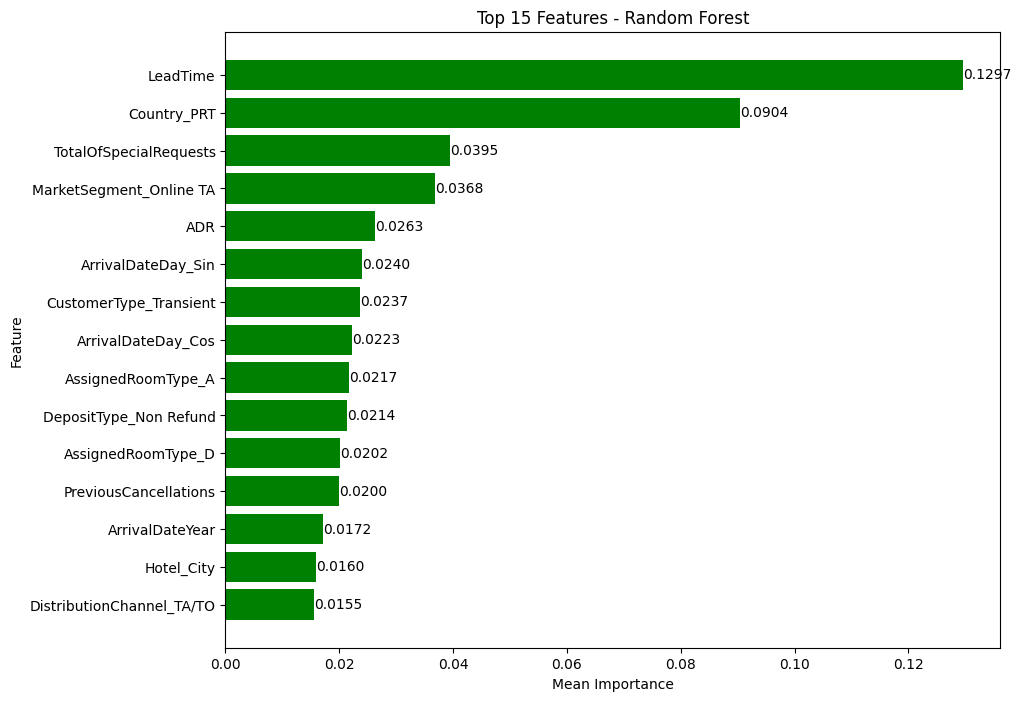

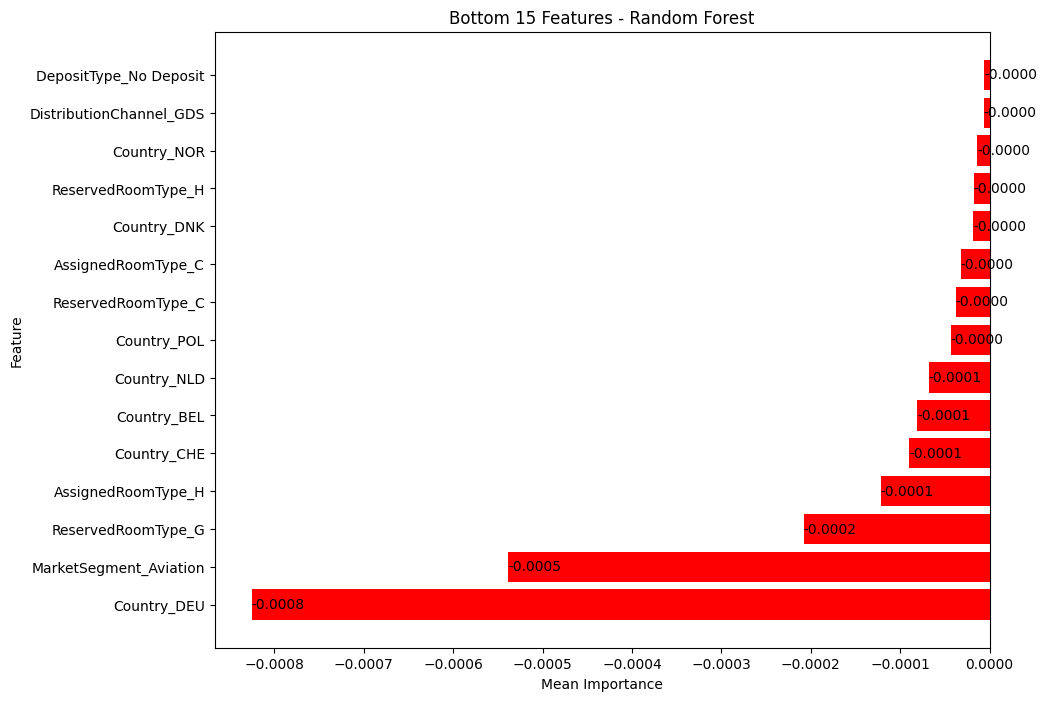

In [20]:
# Top features
top_features_sorted = top_features.sort_values(by='Mean Importance', ascending=True)

plt.figure(figsize=(10, 8))
bars = plt.barh(top_features_sorted['Feature'], top_features_sorted['Mean Importance'], color='green')
plt.xlabel("Mean Importance")
plt.ylabel("Feature")
plt.title("Top 15 Features - Random Forest")


for bar, value in zip(bars, top_features_sorted['Mean Importance']):
    plt.text(value, bar.get_y() + bar.get_height()/2, f'{value:.4f}', va='center')

plt.show()

# Bottom features
bottom_features_sorted = bottom_features.sort_values(by='Mean Importance', ascending=True)

plt.figure(figsize=(10, 8))
bars = plt.barh(bottom_features_sorted['Feature'], bottom_features_sorted['Mean Importance'], color='red')
plt.xlabel("Mean Importance")
plt.ylabel("Feature")
plt.title("Bottom 15 Features - Random Forest")


for bar, value in zip(bars, bottom_features_sorted['Mean Importance']):
    plt.text(value, bar.get_y() + bar.get_height()/2, f'{value:.4f}', va='center')

plt.show()


## New model with selected features

In [21]:
# Extract the mean importance scores
importances_mean = perm_importance.importances_mean

# Setting a threshold for most important features
importance_threshold = 0.001

# Select the indices of features whose importance is above the threshold
important_features_idx = sorted_idx[importances_mean > importance_threshold]

# Retrieve the names of the selected features
selected_feature_names = feature_names[important_features_idx]

# Print the number of selected features
print(f"Number of selected features: {len(selected_feature_names)}")


Number of selected features: 49


In [1]:
# Filtering the original datasets to select the top features for new dataset
X_train_smote_selected = X_train_smote[selected_feature_names]
X_val_selected = X_val[selected_feature_names]
X_test_selected = X_test[selected_feature_names]


NameError: name 'X_train_smote' is not defined

In [23]:
# Training the new model with the selected features
best_xgb_selected = XGBClassifier(random_state=42)

In [24]:
param_dist = {
    'n_estimators': [100, 150, 200],
    'max_depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'gamma': [0.1, 0.3, 0.5],
    'min_child_weight': [1, 3, 5],
    'reg_lambda': [0.1, 1.0, 5.0],
    'reg_alpha': [0.1, 0.5, 1.0]
}

In [27]:
# RandomizedSearch
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='f1_weighted'
)

random_search.fit(X_train_smote_selected, y_train_smote)

print(f"Best parameters found: {random_search.best_params_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found: {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'n_estimators': 150, 'min_child_weight': 5, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 0.6}


In [28]:
# Using best model for prediction
best_xgb_selected = random_search.best_estimator_

y_train_pred = best_xgb_selected.predict(X_train_smote_selected)
y_val_pred = best_xgb_selected.predict(X_val_selected)
y_test_pred = best_xgb_selected.predict(X_test_selected)



Train Set Results
              precision    recall  f1-score   support

           0       0.86      0.89      0.87     42189
           1       0.87      0.84      0.85     42189
           2       0.88      0.82      0.85     42189
           3       0.90      0.96      0.93     42189

    accuracy                           0.88    168756
   macro avg       0.88      0.88      0.87    168756
weighted avg       0.88      0.88      0.87    168756



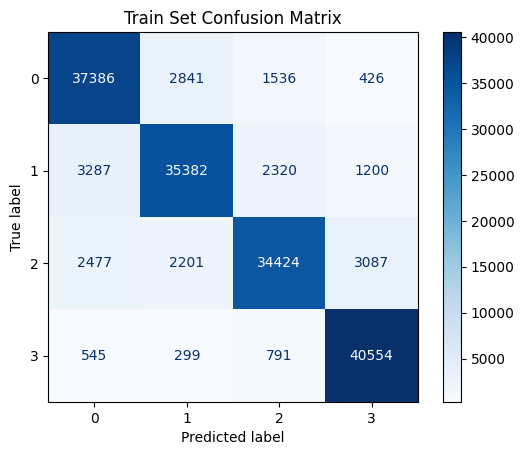

Validation Set Results
              precision    recall  f1-score   support

           0       0.86      0.87      0.87     10499
           1       0.80      0.80      0.80      4817
           2       0.46      0.39      0.42      1233
           3       0.15      0.20      0.17       166

    accuracy                           0.81     16715
   macro avg       0.57      0.57      0.57     16715
weighted avg       0.81      0.81      0.81     16715



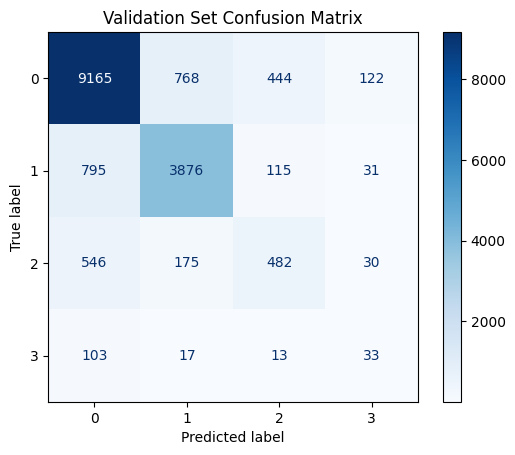

Test Set Results
              precision    recall  f1-score   support

           0       0.86      0.87      0.87     22478
           1       0.80      0.79      0.79     10433
           2       0.47      0.42      0.44      2557
           3       0.16      0.21      0.19       349

    accuracy                           0.81     35817
   macro avg       0.57      0.57      0.57     35817
weighted avg       0.81      0.81      0.81     35817



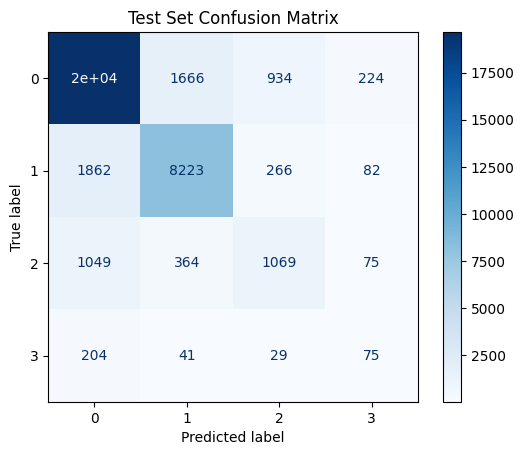

In [32]:
# Confusion matrix train, validation and test results

from sklearn.metrics import classification_report, confusion_matrix

# Train
print("Train Set Results")
print(classification_report(y_train_smote, y_train_pred))
train_cm = confusion_matrix(y_train_smote, y_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=train_cm)
disp.plot(cmap=plt.cm.Blues, colorbar=True)
plt.title("Train Set Confusion Matrix")
plt.show()

# Validation
print("Validation Set Results")
print(classification_report(y_val_encoded, y_val_pred))
val_cm = confusion_matrix(y_val_encoded, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=val_cm)
disp.plot(cmap=plt.cm.Blues, colorbar=True)
plt.title("Validation Set Confusion Matrix")
plt.show()

# Test
print("Test Set Results")
print(classification_report(y_test_encoded, y_test_pred))
test_cm = confusion_matrix(y_test_encoded, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm)
disp.plot(cmap=plt.cm.Blues, colorbar=True)
plt.title("Test Set Confusion Matrix")
plt.show()
